###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 parts of this notebook are from [this Jupyter notebook](https://nbviewer.jupyter.org/github/krischer/seismo_live/blob/master/notebooks/Computational%20Seismology/The Finite-Difference Method/fd_ac1d.ipynb) by Heiner Igel ([@heinerigel](https://github.com/heinerigel)), Lion Krischer ([@krischer](https://github.com/krischer)) and Taufiqurrahman ([@git-taufiqurrahman](https://github.com/git-taufiqurrahman)) which is a supplemenatry material to the book [Computational Seismology: A Practical Introduction](http://www.computational-seismology.org/),  additional modifications by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

###### Translated by Huizhe Di @ SCSIO

## 有限差分法求解一维声学波动方程

在之前的讲座中，我们推导了运动偏微分方程的声学和弹性近似，描述了地震波在三维各向同性弹性介质中的传播。对于均匀声介质，我们用格林函数导出了解析解。最后，我们讨论了连续介质中材料参数和波场的离散化和偏导数的有限差分近似。

在这一节中，我们通过使用有限差分方法求解均匀介质的一维声波方程来总结前面所有讲座的结果。

## 有限差分方法

常密度的一维声学波动方程为

\begin{equation}
\frac{\partial^2 p(x,t)}{\partial t^2} \ = \ vp(x)^2 \frac{\partial^2 p(x,t)}{\partial x^2} + f(x,t) \nonumber
\end{equation}

压力 $p$, 声学速度 $vp$ 和震源项 $f$. 我们可以把震源项分成空间和时间两部分。在空间上，我们假设源被定位在一个点上 $x_s$. 因此，空间源贡献为一个 Dirac $\delta$-function $\delta(x-x_s)$. 时间源部分是任意子波 $s(t)$:

\begin{equation}
\frac{\partial^2 p(x,t)}{\partial t^2} \ = \ vp(x)^2 \frac{\partial^2 p(x,t)}{\partial x^2} + \delta(x-x_s)s(t) \nonumber
\end{equation}

两个二阶导数都可以用3点差公式近似。例如对于时间导数，我们得到:

\begin{equation}
\frac{\partial^2 p(x,t)}{\partial t^2} \ \approx \ \frac{p(x,t+dt) - 2 p(x,t) + p(x,t-dt)}{dt^2}, \nonumber
\end{equation}

空间导数也是一样的: 

\begin{equation}
\frac{\partial^2 p(x,t)}{\partial x^2} \ \approx \ \frac{p(x+dx,t) - 2 p(x,t) + p(x-dx,t)}{dx^2}, \nonumber
\end{equation}

将这些近似值导入波动方程，我们就可以将时间步长 $t$ 压强p(x)作为时刻$t$(现在)和$t-dt$(过去)的压强的函数。 这被称为一个 **显式时间积分方案** 允许 $extrapolation$ 空间依赖领域的未来，只看最近的邻居.


对离散空间格点处的纵波速度波场和压力波场进行离散处理 $i = 0, 1, 2, ..., nx$ 和时间步长 $n = 0, 1, 2, ..., nt$, 我们可以用以下方法替换与时间相关的部分(上索引时间，下索引空间)

\begin{equation}
 \frac{p_{i}^{n+1} - 2 p_{i}^n + p_{i}^{n-1}}{\mathrm{d}t^2} \ = \ vp_{i}^2 \biggl( \frac{\partial^2 p}{\partial x^2}\biggr) \ + \frac{s_{i}^n}{dx} \nonumber
\end{equation}

The $\delta$-function $\delta(x-x_s)$ 源项近似于车厢函数:

$$
\delta_{bc}(x) = \left\{
\begin{array}{ll}
	1/dx &|x|\leq dx/2 \\
	0 &\text{elsewhere} 	
\end{array}
\right.
$$

求解 $p_{i}^{n+1}$ 得到外推式:


\begin{equation}
p_{i}^{n+1} \ = \ vp_i^2 \mathrm{d}t^2 \left( \frac{\partial^2 p}{\partial x^2} \right) + 2p_{i}^n - p_{i}^{n-1} + \frac{\mathrm{d}t^2}{dx} s_{i}^n
\end{equation}

空间导数由

\begin{equation}
\frac{\partial^2 p(x,t)}{\partial x^2} \ \approx \ \frac{p_{i+1}^{n} - 2 p_{i}^n + p_{i-1}^{n}}{\mathrm{d}x^2} \nonumber
\end{equation}

Eq. (1) 是有限差分建模代码的核心.因为我们推导了均匀介质中波传播的解析解，我们应该测试类似介质的第一个代码实现，通过设置:

\begin{equation}
vp_i = vp0\notag
\end{equation}

在每个空间网格点上 $i = 0, 1, 2, ..., nx$, 为了将数值解与解析解进行比较. 为了完整地描述这个问题，我们还必须定义初始条件和边界条件. **初始条件** 是 

\begin{equation}
p_{i}^0 = 0, \nonumber
\end{equation}

因此，建模从每个空间网格点的零压力振幅开始 $i = 0, 1, 2, ..., nx$. 像 **边界条件**, 我们假设 

\begin{align}
p_{0}^n = 0, \nonumber\\
p_{nx}^n = 0, \nonumber\\
\end{align}

对于所有时间步长 n. **Dirichlet boundary condition**, 它导致了人工边界反射，这显然不能描述均匀介质。现在，我们只是扩展模型，这样边界反射就不会被记录在接收位置。

Let's implement it ...

In [1]:
# Import Libraries (PLEASE RUN THIS CODE FIRST!) 
# ----------------------------------------------
import numpy as np
import matplotlib
# Show Plot in The Notebook
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

# Sub-plot Configuration
# ----------------------
from matplotlib import gridspec 

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Definition of modelling parameters
# ----------------------------------

nx   = 1000         # number of grid points in x-direction
dx   = 0.5          # grid point distance in x-direction
vp0  = 333.         # wave speed in medium (m/s)
isrc = 499          # source location in grid in x-direction
ir   = 730          # receiver location in grid in x-direction
nt   = 1001         # maximum number of time steps
dt   = 0.0010       # time step

### 震源时间函数

为了激发波在一维均匀模型中的传播，我们使用高斯函数的一阶导数:

\begin{equation}
s(t) = -2 (t-t_0) f_0^2 exp(-f_0^2 (t-t_0)^2) \nonumber
\end{equation}

作为离散源位置 $isrc$ 上的源时间函数. $t_0$ 表示时移， $f_0$ 表示震源的主频.

Source frequency = 25.0 Hz


<IPython.core.display.Javascript object>


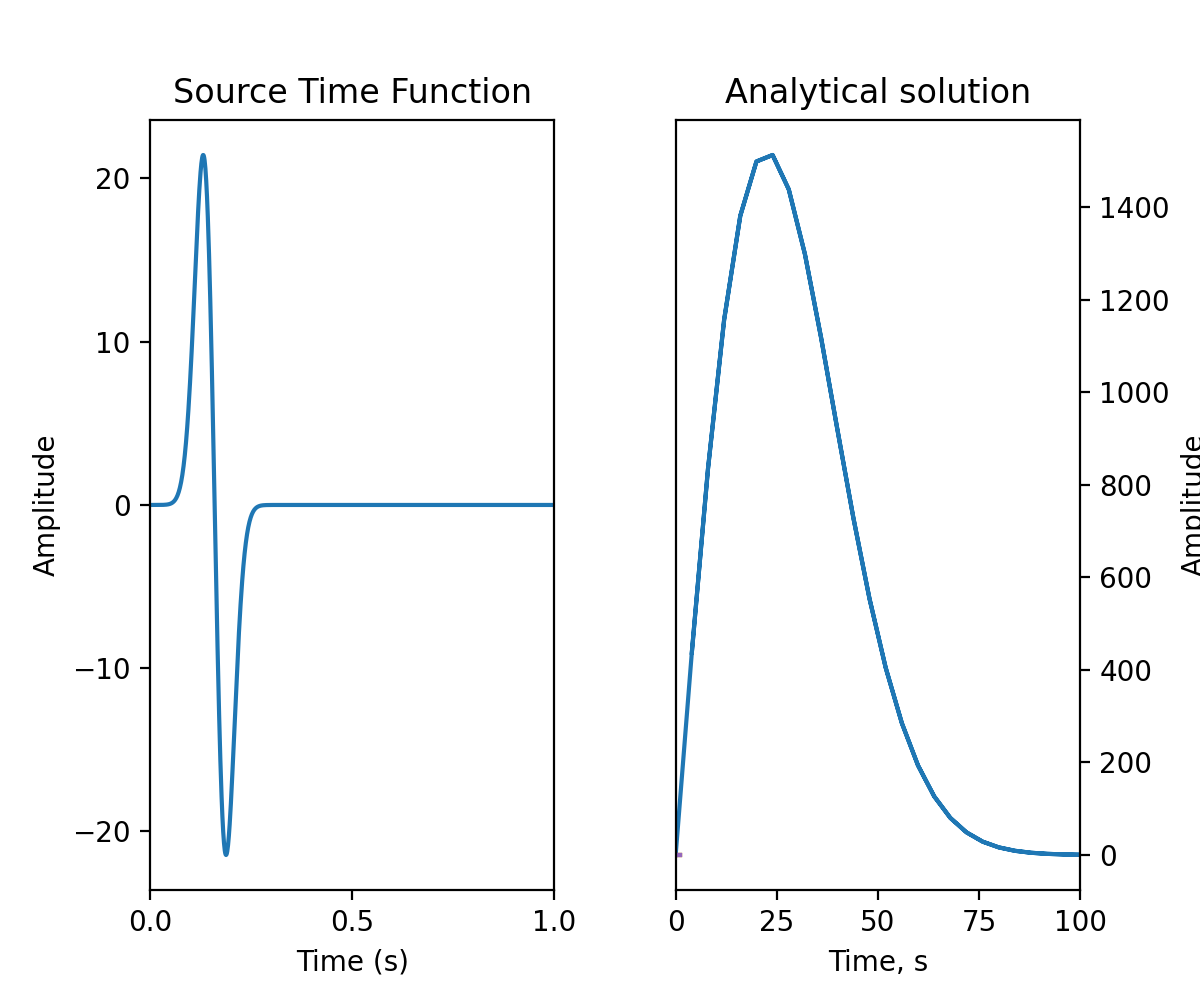

In [4]:
# Plot Source Time Function 
# -------------------------

f0   = 25. # dominant frequency of the source (Hz)
t0   = 4./ f0 # source time shift

print('Source frequency =', f0, 'Hz')

# Source time function (Gaussian)
# -------------------------------
src  = np.zeros(nt + 1)
time = np.linspace(0 * dt, nt * dt, nt)

# 1st derivative of a Gaussian
src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))

# Plot position configuration
# ---------------------------
plt.ion()
fig1 = plt.figure(figsize=(6, 5))
gs1  = gridspec.GridSpec(1, 2, width_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Plot source time function
# -------------------------
ax1  = plt.subplot(gs1[0])
ax1.plot(time, src) # plot source time function
ax1.set_title('Source Time Function')
ax1.set_xlim(time[0], time[-1])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# Plot source spectrum
# --------------------
ax2  = plt.subplot(gs1[1])
spec = np.fft.fft(src) # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt / 4.) # time domain to frequency domain
ax2.plot(np.abs(freq), np.abs(spec)) # plot frequency and amplitude
ax2.set_xlim(0, 100) # only display frequency from 0 to 250 Hz
ax2.set_title('Source Spectrum')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()

### 解析解

我们计算了均匀声学波动方程的格林函数

\begin{equation}
\frac{\partial^2}{\partial t^2} G(x,t;x_s, t_s) \ - \ vp_0^2 \Delta G(x,t;x_s, t_s) \ = \delta (x-x_s) \delta (t-t_s) \nonumber
\end{equation}

这里 $\Delta$ 代表Laplace算子, $\delta-$function的定义为:

\begin{equation}
\delta(x) = \left\{
\begin{array}{ll}
	\infty &x=0 \\
	0 &x\neq 0 	
\end{array}
\right.\notag
\end{equation}

约束为:

\begin{equation}
\int_{-\infty}^{\infty} \delta(x)\; dx = 1.\notag
\end{equation}

当比较数值解和解析解时，在极限下导致 $\delta-$function 将变得非常重要. boxcar function就是一个例子

$$
\delta_{bc}(x) = \left\{
\begin{array}{ll}
	1/dx &|x|\leq dx/2 \\
	0 &\text{elsewhere} 	
\end{array}
\right.
$$

满足以下属性: $dx\rightarrow0$. 这些函数用来适当缩放源项以获得正确的绝对振幅.

为了描述声学波动方程的解析解，我们还使用单位阶跃函数，也称为Heaviside函数，定义为

$$
H(x) = \left\{
\begin{array}{ll}
    0 &x<0 \\
	1 &x \geq 0 	
\end{array}
\right.
$$

Heaviside function是 $\delta-$function的积分(反之，$\delta$-function 数被定义为Heaviside function的导数). 在一维情况下，格林函数与Heaviside函数成正比. 


$$
G=\frac{1}{2vp_0}H\left(t-\frac{|x|}{vp_0}\right)
$$

由于对任意源时间函数的响应可以通过卷积得到

$$
G_{seis} = G(x,t;x_s,t_s) * s(t),
$$

这意味着传播波形是源时间函数的积分。给出了一阶导数为高斯的源时间函数的响应。

In [8]:
# Analytical solution
# -------------------
G = time * 0.

# Initialize coordinates
# ----------------------
x = np.arange(nx)
x = x * dx       # coordinate in x-direction

for it in range(nt): # Calculate Green's function (Heaviside function)
    if (time[it] - np.abs(x[ir] - x[isrc]) / vp0) >= 0:
        G[it] = 1. / (2 * vp0)
Gc = np.convolve(G, src * dt)
Gc = Gc[0:nt]
lim = Gc.max() # get limit value from the maximum amplitude

# Plotting convolution of Green's function with source wavelet
plt.plot(time, Gc)
plt.title("Analytical solution" )
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

## 数值解与解析解的比较

在下面的代码中，我们用三点差分算子求解齐次声波方程，并将数值结果与解析解进行比较。

<IPython.core.display.Javascript object>


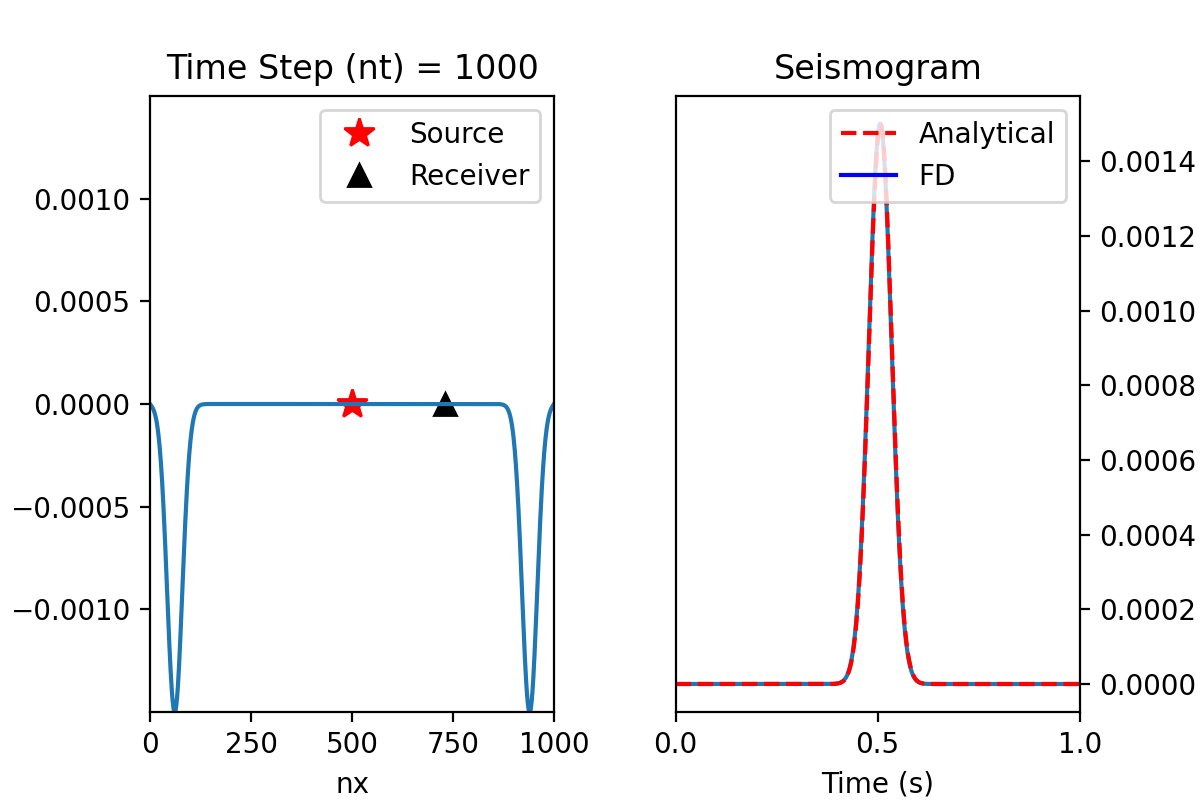

In [11]:
# Plot Snapshot & Seismogram (PLEASE RERUN THIS CODE AGAIN AFTER SIMULATION!) 
# ---------------------------------------------------------------------------

# Initialize empty pressure arrays
# --------------------------------
p    = np.zeros(nx) # p at time n (now)
pold = np.zeros(nx) # p at time n-1 (past)
pnew = np.zeros(nx) # p at time n+1 (present)
d2px = np.zeros(nx) # 2nd space derivative of p

# Initialize model (assume homogeneous model)
# -------------------------------------------
vp    = np.zeros(nx)
vp    = vp + vp0       # initialize wave velocity in model

# Initialize empty seismogram
# ---------------------------
seis = np.zeros(nt) 

# Plot position configuration
# ---------------------------
plt.ion()
fig2  = plt.figure(figsize=(6, 4))
gs2   = gridspec.GridSpec(1, 2, width_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Plot 1D wave propagation
# ------------------------
# Note: comma is needed to update the variable
ax3  = plt.subplot(gs2[0])
leg1,= ax3.plot(isrc, 0, 'r*', markersize=11) # plot position of the source in snapshot
leg2,= ax3.plot(ir, 0, 'k^', markersize=8) # plot position of the receiver in snapshot
up31,= ax3.plot(p) # plot pressure update each time step
ax3.set_xlim(0, nx)
ax3.set_ylim(-lim, lim)
ax3.set_title('Time Step (nt) = 0')
ax3.set_xlabel('nx')
ax3.set_ylabel('Amplitude')
ax3.legend((leg1, leg2), ('Source', 'Receiver'), loc='upper right', fontsize=10, numpoints=1)

# Plot seismogram 
# ---------------
# Note: comma is needed to update the variable
ax4  = plt.subplot(gs2[1])
leg3,= ax4.plot(0,0,'r--',markersize=1) # plot analytical solution marker
leg4,= ax4.plot(0,0,'b-',markersize=1) # plot numerical solution marker
up41,= ax4.plot(time, seis) # update recorded seismogram each time step
up42,= ax4.plot([0], [0], 'r|', markersize=15) # update time step position
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.set_xlim(time[0], time[-1])
ax4.set_title('Seismogram')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Amplitude')
ax4.legend((leg3, leg4), ('Analytical', 'FD'), loc='upper right', fontsize=10, numpoints=1)

plt.plot(time,Gc,'r--') # plot analytical solution
plt.show()

In [12]:
# 1D Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------

# Calculate Partial Derivatives
# -----------------------------
for it in range(nt):
    
    # FD approximation of spatial derivative by 3 point operator
    for i in range(1, nx - 1):
        d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2

    # Time Extrapolation
    # ------------------
    pnew = 2 * p - pold + vp ** 2 * dt ** 2 * d2px

    # Add Source Term at isrc
    # -----------------------
    # Absolute pressure w.r.t analytical solution
    pnew[isrc] = pnew[isrc] + src[it] / dx * dt ** 2
                
    # Remap Time Levels
    # -----------------
    pold, p = p, pnew
    
    # Output Seismogram
    # -----------------
    seis[it] = p[ir]
    
    # Update Data for Wave Propagation Plot
    # -------------------------------------
    idisp = 2 # display frequency
    if (it % idisp) == 0:
        ax3.set_title('Time Step (nt) = %d' % it)
        up31.set_ydata(p)
        up41.set_ydata(seis)
        up42.set_data(time[it], seis[it])
        plt.gcf().canvas.draw()

## 我们学习到:

* 一维声学波动方程的实现
* 理解模拟的输入参数和生成的图
* 修改震源和接收位置，观察对地震图的影响
* 让你探索有限差分法